# Analysis of the MOT data from the laser room

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

filepath_drive = "/content/drive/.shortcut-targets-by-id/1gvWPu9Q7IMW4aHUuFD-yUxq_kMi59WWg/20220922-193641"

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/data-engineering-utokyo/notebooks

/content/drive/MyDrive/data-engineering-utokyo/notebooks


In [ ]:
import sys
sys.path.insert(0,'..')

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

from src.constants.mot_constants import c_cmos_laser_room
from src.recorders.static_recorder import StaticRecorder
from src.analyses.analysis import ResultParameter
from src.analyses.image_analysis import ImageAnalysis
from src.analyses.mkdir import create_folders
from src.analyses.runner import Runner
from src.analyses.fit_mot_number import MOTMLE

## Image analysis

In [ ]:
# Input 
c = c_cmos_laser_room
min_signal = 0
time_interval = (
    datetime(2022, 9, 22, 0, 0, 0), 
    datetime(2022, 9, 22, 23, 59, 0)
    )
use_n_reference_images = 50
dead_pixel_percentile = 0 # [%], must between 0 and 100
timelog_filepath = filepath_drive + "/timelog.csv"

# Output 
run_name = f"Run3"
plot_path = f"{filepath_drive}/plots/{run_name}/" 
result_path = f"{filepath_drive}/results/{run_name}/"

In [ ]:
# Make dirs
create_folders(plot_path, result_path)

# Setup result parameters
result_param_image = ResultParameter(
    image_src=plot_path+"image/",
    image_extension=".png",
    result_filepath=result_path+"image_analysis_results.csv"
    )

In [ ]:
# Prepare file recorder
timelog_df = pd.read_csv(timelog_filepath)
timelog_df["filename"] = timelog_df["File Name"]
timelog_df["filepath"] = timelog_df["File Name"].apply(lambda s: f"{filepath_drive}/{s}")
timelog_df["datetime"] = timelog_df["Time"].apply(lambda s: f"2022-09-22 {s}").apply(pd.Timestamp)
timelog_df["timestamp"] = timelog_df["datetime"].values.astype(np.int64)
min_time = timelog_df["timestamp"].min()
timelog_df["seconds"] = timelog_df["timestamp"].apply(lambda ns: (ns - min_time)/1e9)
timelog_df

,File Name,Time,filename,filepath,datetime,timestamp,seconds
0,cmos001.csv,19:37:25.257,cmos001.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:25.257,1663875445257000000,0.000
1,cmos002.csv,19:37:26.257,cmos002.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:26.257,1663875446257000000,1.000
2,cmos003.csv,19:37:27.258,cmos003.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:27.258,1663875447258000000,2.001
3,cmos004.csv,19:37:28.258,cmos004.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:28.258,1663875448258000000,3.001
4,cmos005.csv,19:37:29.257,cmos005.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:29.257,1663875449257000000,4.000
...,...,...,...,...,...,...,...
697,cmos698.csv,19:49:03.257,cmos698.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:49:03.257,1663876143257000000,698.000
698,cmos699.csv,19:49:04.257,cmos699.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:49:04.257,1663876144257000000,699.000
699,cmos700.csv,19:49:05.257,cmos700.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:49:05.257,1663876145257000000,700.000
700,cmos701.csv,19:49:06.258,cmos701.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:49:06.258,1663876146258000000,701.001


In [ ]:
# Setup recorders
image_recorder = StaticRecorder(df=timelog_df)

# Setup analyses
reference_image_filepaths = image_recorder.get_table().head(use_n_reference_images)["filepath"]

In [ ]:
perform_analysis = MOTMLE(c=c, 
                          references=reference_image_filepaths,
                          do_subtract_dead_pixels=False,
                          dead_pixel_percentile=dead_pixel_percentile).perform_analysis
image_analysis = ImageAnalysis(
    recorder=image_recorder,
    perform_analysis=perform_analysis, 
    result_param=result_param_image,
    min_signal=min_signal,
    time_interval=time_interval
    )
    
# Setup runner
runner = Runner(analyses=[image_analysis])
runner.run(cycles=1, period_s=5)

Output hidden; open in https://colab.research.google.com to view.

# MOT lifetime
After we fitted the MOT number for each image and saved it to a csv file, we now plot it and calculate the MOT lifetime. 

In [ ]:
result_df = pd.read_csv(result_path + "image_analysis_results.csv")
result_df

,File Name,Time,filename,filepath,datetime,timestamp,seconds,A,A_unc,sigma_x,...,mu_x,mu_x_unc,mu_y,mu_y_unc,C,C_unc,X-squared,p-value,R^2,fit_successful
0,cmos001.csv,19:37:25.257,cmos001.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:25.257,1663875445257000000,0.000,59214.236146,323.875096,0.000012,...,0.000936,5.611683e-08,0.000354,4.202098e-08,13.550826,0.727265,395016.711926,0.000000e+00,0.886004,True
1,cmos002.csv,19:37:26.257,cmos002.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:26.257,1663875446257000000,1.000,70356.716975,662.835087,0.000020,...,0.000944,1.422493e-07,0.000366,7.185731e-08,7.461190,1.057216,464565.174722,0.000000e+00,0.754498,True
2,cmos003.csv,19:37:27.258,cmos003.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:27.258,1663875447258000000,2.001,59506.249863,365.647201,0.000026,...,0.000947,1.190750e-07,0.000372,4.195473e-08,8.922091,0.475633,205780.776546,0.000000e+00,0.894220,True
3,cmos004.csv,19:37:28.258,cmos004.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:28.258,1663875448258000000,3.001,44030.053257,229.009989,0.000012,...,0.000934,5.537078e-08,0.000372,4.130517e-08,23.581889,0.487402,543165.336700,0.000000e+00,0.897747,True
4,cmos005.csv,19:37:29.257,cmos005.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:37:29.257,1663875449257000000,4.000,62960.727519,163.194229,0.000013,...,0.000935,2.888077e-08,0.000372,1.984999e-08,14.247779,0.344897,170898.706692,0.000000e+00,0.972560,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,cmos698.csv,19:49:03.257,cmos698.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:49:03.257,1663876143257000000,698.000,796.827266,11.948753,0.000013,...,0.000934,1.624891e-07,0.000371,1.165087e-07,3.406550,0.025514,11357.533172,1.663271e-20,0.513334,True
698,cmos699.csv,19:49:04.257,cmos699.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:49:04.257,1663876144257000000,699.000,1474.594351,19.248527,0.000027,...,0.000951,2.842642e-07,0.000359,7.610049e-08,2.902794,0.025205,7265.118129,1.000000e+00,0.659519,True
699,cmos700.csv,19:49:05.257,cmos700.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:49:05.257,1663876145257000000,700.000,1004.398480,13.480975,0.000015,...,0.000936,1.620894e-07,0.000373,1.034918e-07,3.430601,0.026496,10682.819746,1.099435e-06,0.577271,True
700,cmos701.csv,19:49:06.258,cmos701.csv,/content/drive/.shortcut-targets-by-id/1gvWPu9...,2022-09-22 19:49:06.258,1663876146258000000,701.001,1398.158190,11.954398,0.000009,...,0.000930,6.360404e-08,0.000360,9.575650e-08,3.210669,0.025743,8877.293987,1.000000e+00,0.763717,True


In [ ]:
# Prepare data
x = result_df["seconds"]
y = result_df["A"]

Text(0, 0.5, 'MOT number')

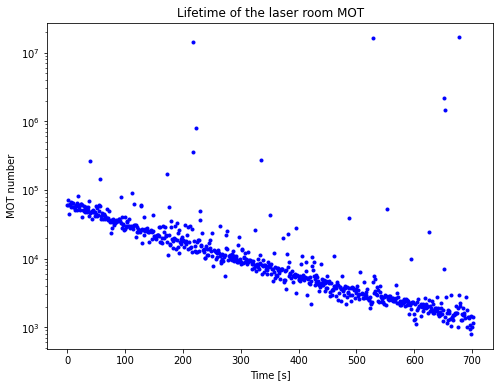

In [ ]:
# Plot
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
plt.plot(x, y, "b.")
plt.yscale("log")
ax.set_title("Lifetime of the laser room MOT")
ax.set_xlabel('Time [s]')
ax.set_ylabel('MOT number')

## Perform fit

In [ ]:
# Clean data
cleaned_df = result_df[~result_df['A'].isnull()]  # Only rows without Nan MOT number
cleaned_df = cleaned_df[cleaned_df.A < 2e5]       # Throw away obvious outliers
x = cleaned_df["seconds"]
y = cleaned_df["A"]

In [ ]:
from scipy.optimize import curve_fit

def exp_decay(t, N0, lmbda, offset):
    """ Time t, initial MOT number N0 at t=0, decay constant lmbda = 1/tau 
        with decay time tau. 
    """
    return N0 * np.exp(-lmbda * t) + offset

popt, pcov = curve_fit(exp_decay, x, y)
popt, pcov

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([6.31686538e+04, 5.90094959e-03, 6.06798097e+02]),
 array([[ 2.08242141e+06,  1.35669609e-01, -1.77600902e+05],
        [ 1.35669609e-01,  1.13227861e-07,  2.35261664e-01],
        [-1.77600902e+05,  2.35261664e-01,  7.24517749e+05]]))

In [ ]:
N0, lmbda, offset = popt[0], popt[1], popt[2]
perr = np.sqrt(np.diag(pcov))
N0_unc, lmbda_unc, offset_unc = perr[0], perr[1], perr[2]

In [ ]:
!pip install uncertainties
from uncertainties import unumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 5.3 MB/s 


In [ ]:
u_lmbda = unumpy.uarray([lmbda], [lmbda_unc])
half_life_time = math.log(2) / u_lmbda
print(f"The half life time of the MOT is {unumpy.nominal_values(half_life_time)} pm {unumpy.std_devs(half_life_time)} s.")

0.00033649347887100035
[0.005900949591682864+/-0.00033649347887100035]
The half life time of the MOT is [117.46366746] pm [6.69820297] s.


In [ ]:
# Plot with fit
y_fit = [exp_decay(t, N0, lmbda, offset) for t in x]

117.4636674641157

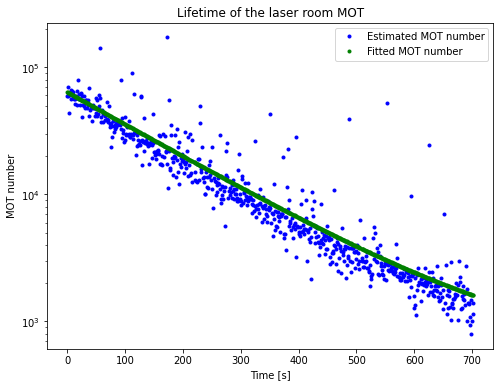

In [ ]:
# Plot
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
plt.plot(x, y, "b.", label="Estimated MOT number")
plt.plot(x, y_fit, "g.", label="Fitted MOT number")
plt.yscale("log")
ax.set_title("Lifetime of the laser room MOT")
ax.set_xlabel('Time [s]')
ax.set_ylabel('MOT number')
plt.legend()
plt.savefig(result_path+"Lifetime.png")

In [ ]:
!git status

On branch online
Your branch is up to date with 'origin/online'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../src/notebooks/beamtime_analysis.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git status